# Our initialization strategy

This notebook implements the algorithms for computing weights and biases of our new initialization strategy for neural networks. The neural networks we work with have (rank $k$) max-out activation functions, which means each unit performs
$$x \mapsto max(a_{i, 1}w_i*x + b_{i, 1}, \ a_{i, 2}w_i*x + b_{i, 2},\ \ldots \ ,\ a_{i, k}w_i*x + b_{i, k} )$$
on the input.

The proposed initialization strategy follows three steps (per layer of size $m_l$):
1. Sample weights $\{ w_i \}_{i = 1, \ldots, m_l}$ from the unit sphere (uniformly) for all units in the layer.
2. Pick a subset $X \subseteq \mathcal{X}$ of size $N$ of the unlabelled data set (where $N$ is a parameter set by the user).
3. For unit $i$, pick $\{ a_{i, j} \}_{j = 1, \ldots, k} \subseteq \mathbb{R}$. Set $\{ b_{i, j} \}_{j = 1, \ldots, k}$ so that the linear regions $R_{i, j}$ contain approximately the same number of points in $X$, i.e. $|X \cap R_{i, j}|$ is independent of $j$.

In [38]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

np.random.seed(65432)

In [39]:
k = 3     # rank of max-out
m_l = 16   # size of the layer

## Generating an input dataset

To test our method, we generate a dataset of points in $\mathbb{R}^3$. Since this data set will be "small enough", the step 2 of the initialization strategy can be skipped. 

In [40]:
d = 2      # dimension of the ambient space
N = 30   # size of the data set

In [41]:
X = np.random.normal(0, 1, (N, d))

Let us visualize the generated data

In [42]:
xs = X[:, 0]
ys = X[:, 1]
#zs = X[:, 2]

<IPython.core.display.Javascript object>


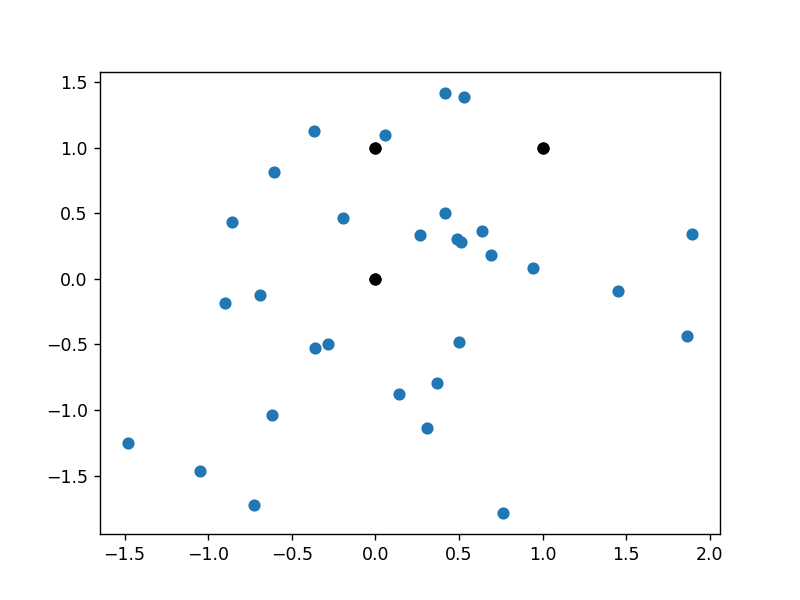

In [43]:
fig = plt.figure()
ax = fig.add_subplot()#projection='2d')
ax.scatter(xs, ys)#, zs)

## Sampling weights

To sample weights uniformly, we will sample them from a normal distribution around the origin and then normalize them.

In [44]:
def sample_weights(nr_weights, dimension):
    W = np.random.normal(0, 1, (nr_weights, dimension))
    
    for i in range(nr_weights):
        w_i = W[i,:]
        while np.array_equal(w_i, np.zeros(dimension)):
            w_i = np.random.normal(0, 1, (1, dimension))
        norm = np.linalg.norm(w_i)
        W[i, :] = w_i/norm
    return W            

In [45]:
W = sample_weights(m_l, d)

Let us visualize the weights. 

In [46]:
Wxs=W[:, 0]
Wys=W[:, 1]
#Wzs=W[:, 2]

<IPython.core.display.Javascript object>


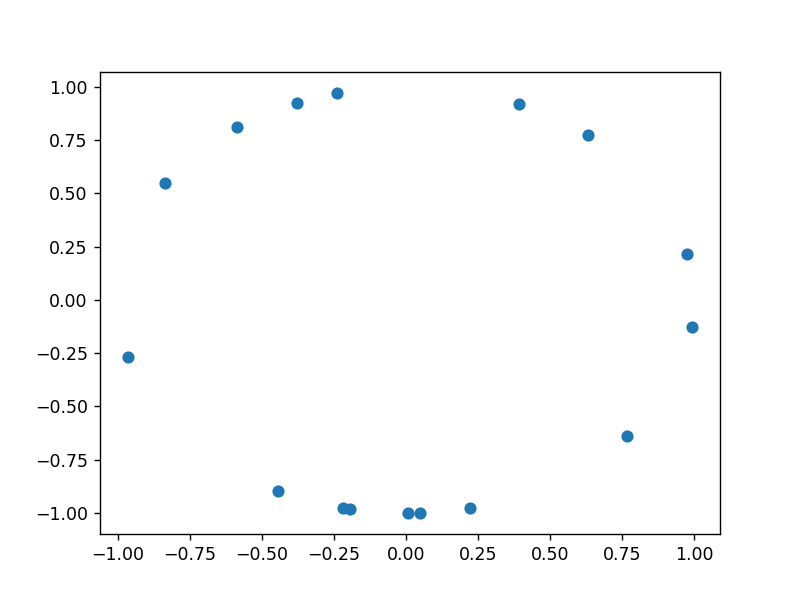

In [47]:
fig1 = plt.figure()
Wax = fig1.add_subplot()#projection='3d')
Wax.scatter(Wxs, Wys)#, Wzs)

## Sampling the borders of linear regions

In this part we focus on a single unit with weight $w_0$. First compute the (length of the) projections of data points in $X$ onto the line $\{ \alpha w_0 \}_{\alpha \in \mathbb{R}}$.

In [48]:
def calculate_projections(w, data):
    data_size, b = data.shape 
    c = 0
    proj = np.zeros(data_size)
    for x in data:
        proj[c] = np.dot(x, w)
        c= c+1
    return proj

In [49]:
proj = np.sort(calculate_projections(W[0, :], X))
print(proj)

[-1.71093138 -1.33574479 -1.07724901 -0.91576193 -0.82358048 -0.74316731
 -0.70124751 -0.46498326 -0.4196837  -0.38326554 -0.11735434 -0.09108293
 -0.04933371  0.05943927  0.19170363  0.29212331  0.33011114  0.36780127
  0.38616974  0.51258211  0.54254857  0.55924196  0.70311428  0.71162639
  0.71568038  0.81239987  0.94107017  1.39911899  1.72638853  1.92231662]


We need to put $k-1$ lines in between these projections so that the number of projections between each consecutive lines is the same. We calculate the batch size and the splits.

In [50]:
batch_size = math.floor(N/k)
print(batch_size)

10


In [51]:
def compute_splits(projections, batch_size, k):
    splits = np.zeros(k-1)
    for i in range (k-1):
        splits[i]=1/2*(projections[(i+1)*batch_size - 1] + projections[(i+1)*batch_size])
    return splits

In [52]:
splits = compute_splits(proj, batch_size, k)
splits

array([-0.25030994,  0.52756534])

We sample the factors $\{ a_{0, j}\}_{j=1, \ldots, k}$ from $\mathcal{U}([0, 1])$ and choose $\{ b_{0, j}\}_{j=1, \ldots, k}$ according to the criteria in step 3 above.

In [53]:
ai = np.random.uniform(0, 1, (k, 1))

In [54]:
ai

array([[0.6303626 ],
       [0.62098328],
       [0.3930228 ]])

Assume you choose a $b_0 = 0.01$.

In [55]:
b_0 = 0.01

Given $b_0$ we can now inductively compute the remaining biases using the formula $$b_{i+1} = b_{i} + s_{i}(a_{i}-a_{i+1}),$$ where $s_i$ is the split between the projection of the $i$-th and the $i+1$-st data point to the line spanned by the weight.

In [56]:
def compute_biases(ai, b_0, splits):
    biases = np.zeros(ai.shape)
    biases[0]=b_0
    for i in range(len(ai)-1):
        if ai[i] == ai[i+1]:
            return None
        biases[i+1] = biases[i] + splits[i]*(ai[i]-ai[i+1])
    return biases

In [57]:
biases = compute_biases(ai, b_0, splits)
biases

array([[0.01      ],
       [0.00765226],
       [0.12791631]])

## Putting it all together

Let us define a function `initialize` that takes the parameters:
1. `X` ... data given in a form of a matrix,
2. `layer_size` ... number of units in the layer,
3. `maxout_rank` ... number of linear regions of the maxout activation,
4. `b0s` ... the vector of $b_{i, 0}$,

and returns the following (in the given order):

1. `A` ... `layer_size`$\times$ `maxout_rank`-array of factors,
2. `W` ... array of `layer_size` $d$-dimensional weight vectors (1 per unit),
3. `B` ... `layer_size`$\times$`maxout_rank`-array of biases.

In [58]:
def initialize_layer(data, layer_size, maxout_rank, b0s):
    N, d = data.shape                                       # compute the dimension of the ambient space and #pts
    A = np.random.uniform(0, 1, (layer_size, maxout_rank))  # initialize the array of factors
    B = np.zeros(shape=(layer_size, maxout_rank))           # initialize the array of biases
    batch_size = math.floor(N/maxout_rank)                  # compute the batch size (for computing splits)
    
    #AW = np.zeros(shape=(layer_size, k, d))
    
    W = sample_weights(layer_size, d)                       # sample the weights for each unit
    
    for i in range(layer_size):                                             # loop over all units
        projections = calculate_projections(W[i, :], data)                  # calculate proj. of pts onto weight
        projections = np.sort(projections)
        splits = compute_splits(projections, batch_size, maxout_rank)       # calculate splits between batches
        B[i, :] = compute_biases(A[i, :], b0s[i], splits)                   # calculate the biases   
        #AW[i] = (np.diag(A[i])*(W[i].transpose() * np.ones((1, d)))).transpose()
        
    return A, W, B

In [59]:
#X2 = np.random.normal(0, 1, (N, 2))
b0s = 0.01 * np.ones(m_l)
A2, W2, B2 = initialize_layer(X, m_l, k, b0s)

## Visualization methods

Below we define methods `visualize_layer_2D` and `visualize_layer_3D`. It is used to plot the data together with the knots of the maxout units. We also provide examples of use.

In [61]:
def visualize_layer_2D(data, A, W, B, nr_units, k, start=0):
    colors = cm.rainbow(np.linspace(0, 1, nr_units))
    fig = plt.figure()
    xs = data[:, 0]
    ys = data[:, 1]
    ax = fig.add_subplot()
    ax.set_xlim(left = -3, right = 3)
    ax.set_ylim(bottom = -3, top = 3)
    ax.scatter(xs, ys, c='black')
    for l in range(nr_units):   
        j=start+l
        w1, w2 = W[j][0], W[j][1]
        x = np.linspace(-3, 3, 2)
        for i in range(k-1):
            plt.plot(x, (-w1*x - (B[j][i]-B[j][i+1])/(A[j][i]-A[j][i+1]))/w2, c=colors[l])

<IPython.core.display.Javascript object>


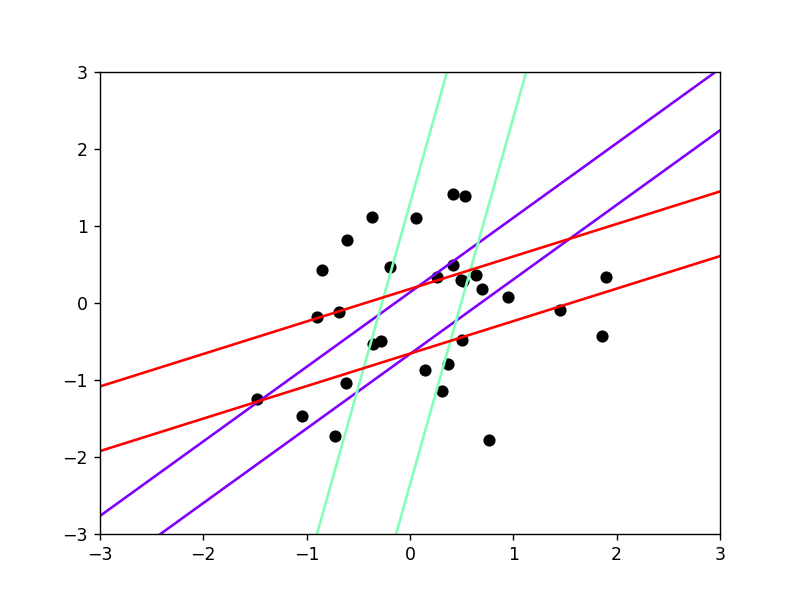

In [125]:
visualize_layer_2D(X, A2, W2, B2, 3, k, start=5)

In [115]:
def visualize_layer_3D(data, A, W, B, nr_units, k, start=0):
    colors = cm.rainbow(np.linspace(0, 1, nr_units))
    fig = plt.figure()
    xs = data[:, 0]
    ys = data[:, 1]
    zs = data[:, 2]
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xs, ys, zs, c='black')
    for l in range(nr_units):   
        j=start+l
        w1, w2, w3 = W[j][0], W[j][1], W[j][2]
        norm = np.linalg.norm(W[j])**2
        x = np.arange(-3, 6, 3)
        y = np.arange(-3, 6, 3)
        xx, yy = np.meshgrid(x, y, sparse=True)
        for i in range(k-1):
            z = (norm*(B[j][i+1]-B[j][i])/(A[j][i]-A[j][i+1])*np.ones(shape=yy.shape) - w2*yy - w1*xx)/w3
            ax.plot_surface(xx, yy, z, color=colors[l], alpha=0.3)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(-3, 3)

In [116]:
X_3D = np.random.normal(0, 1, (N, 3))
A_3D,W_3D,B_3D = initialize_layer(X_3D, m_l, k, b0s)

<IPython.core.display.Javascript object>


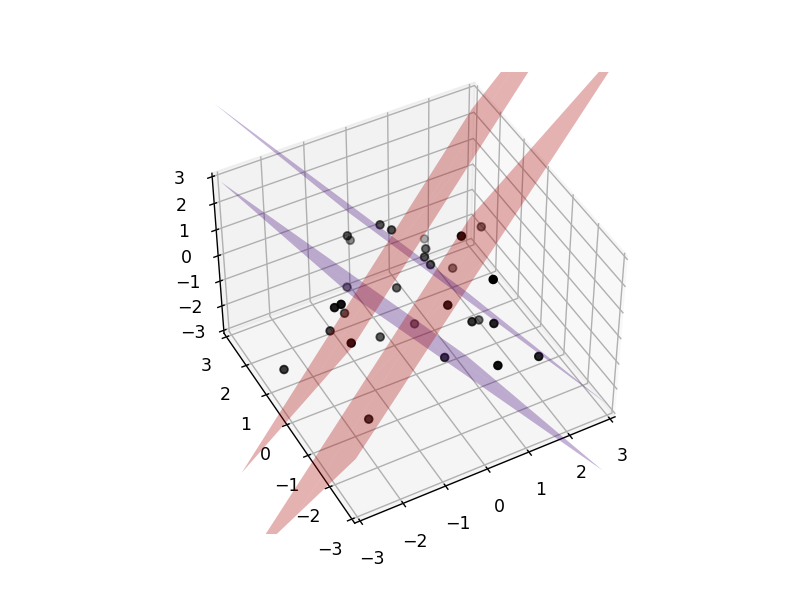

In [122]:
visualize_layer_3D(X_3D, A_3D, W_3D, B_3D, 2, k)

## Initialize network

We use previously defined methods to write a new method, `initialize_network`, that initializes the network layer by layer keeping track of how each layer transforms the data.

In [64]:
def maxout_image(data, A, W, B):
    return data

In [65]:
def initialize_network(data, layer_sizes, maxout_ranks, b0s):
    AA, WW, BB = [], [], []
    for i in range(len(layer_sizes)):
        A, W, B = initialize_layer(data, layer_sizes[i], maxout_ranks[i], np.zeros(layer_sizes[i]))
        AA += [A]
        WW += [W]
        BB += [B]
        data = maxout_image(data, A, W, B)
    return AA, WW, BB

In [66]:
initialize_network(X, [2, 2], [3, 3], 0)

([array([[0.66886167, 0.18814772, 0.97949657],
         [0.15993875, 0.61019945, 0.26882825]]),
  array([[0.65145439, 0.63619378, 0.93961577],
         [0.31285661, 0.39550072, 0.81743647]])],
 [array([[-0.11278431,  0.99361949],
         [ 0.92229413, -0.38648874]]),
  array([[ 0.84298703,  0.53793389],
         [-0.01541556,  0.99988117]])],
 [array([[ 0.        , -0.24460961, -0.45634778],
         [ 0.        ,  0.074095  ,  0.23053346]]),
  array([[ 0.        , -0.00537054, -0.18745439],
         [ 0.        ,  0.04036899, -0.09550378]])])